In [1]:
!pip install emnist
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dropout, Dense
#from mnist import MNIST
import os

In [2]:
import emnist

In [3]:
from tensorflow import keras
from emnist import extract_training_samples
x_train, y_train=extract_training_samples('byclass')
x_train.shape
y_train.shape
from emnist import extract_test_samples
x_test,y_test=extract_test_samples('byclass')
x_test.shape
y_test.shape

(116323,)

In [4]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((697932, 28, 28), (697932,), (116323, 28, 28), (116323,))

In [5]:
img_side = 28

# Reshape tensors to [n, y, x, 1] and normalize the pixel values between [0, 1]
x_train = x_train.reshape(-1, img_side, img_side, 1).astype('float32') / 255.0
x_test = x_test.reshape(-1, img_side, img_side, 1).astype('float32') / 255.0

x_train.shape, x_test.shape

((697932, 28, 28, 1), (116323, 28, 28, 1))

In [6]:
# get number of classes
unique_classes = np.unique(y_train)
num_classes = len(unique_classes)

input_shape = (img_side, img_side, 1)

# weight the classes (to combat the imbalance)
class_weights = dict(enumerate(compute_class_weight('balanced', unique_classes, y_train)))

# Convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [7]:
kernel_size = (5, 5)
def createmodel():
    return Sequential([
        Convolution2D(16, kernel_size=kernel_size, padding='same', input_shape=input_shape, activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        Dropout(0.4),
        #Convolution2D(32, kernel_size=kernel_size, padding='same', activation= 'relu'), #strides=2,
        #MaxPooling2D(pool_size=(2, 2)),
        #BatchNormalization(),
        #Dropout(0.4),
        #Convolution2D(64, kernel_size=kernel_size, padding='same', activation= 'relu'),
        #MaxPooling2D(pool_size =(2,2)),
        #BatchNormalization(),
        #Dropout(0.4),
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(num_classes, activation='softmax'),
    ])

In [8]:
# setting up model to run on cpu, or gpu when avaiable
model = createmodel()
model.compile(loss="categorical_crossentropy",
        optimizer="adam",
        metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 16)        64        
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               803072    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1

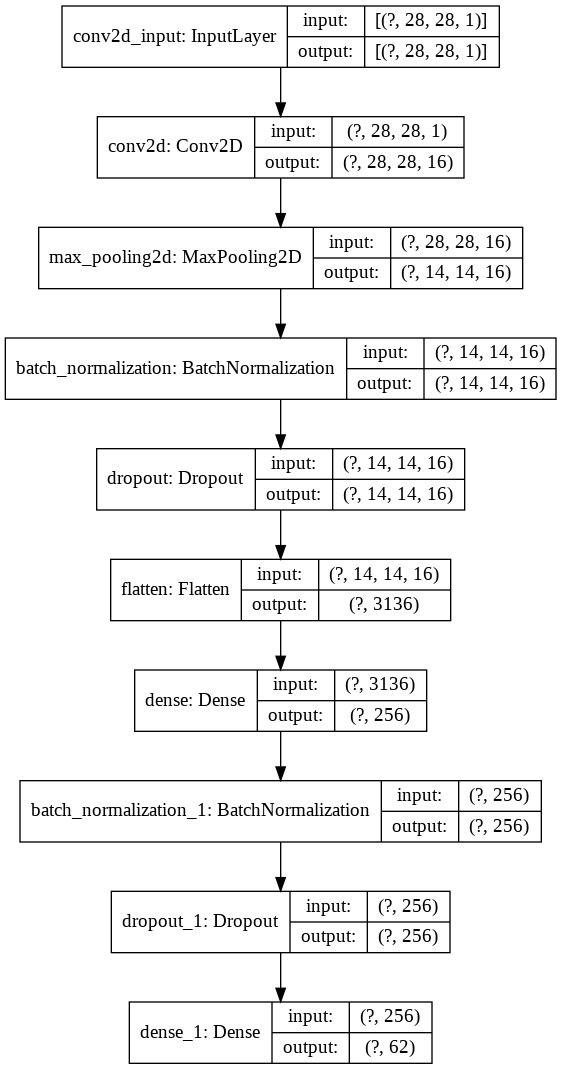

In [9]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

# Train model

In [10]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    verbose=1,
    patience=10,
    restore_best_weights=True)

In [11]:
model.fit(x_train, y_train,
          #class_weight=class_weights,
          batch_size=10000,
          epochs=10,
          verbose=1,
          shuffle=True,
          validation_data=(x_test, y_test),
          callbacks=[es])

Epoch 1/10
70/70 [==============================] - 5s 72ms/step - loss: 1.3200 - accuracy: 0.6482 - val_loss: 3.1692 - val_accuracy: 0.3223
Epoch 2/10
70/70 [==============================] - 4s 63ms/step - loss: 0.7106 - accuracy: 0.7761 - val_loss: 2.9152 - val_accuracy: 0.2865
Epoch 3/10
70/70 [==============================] - 4s 63ms/step - loss: 0.6010 - accuracy: 0.8033 - val_loss: 2.6885 - val_accuracy: 0.2932
Epoch 4/10
70/70 [==============================] - 4s 63ms/step - loss: 0.5511 - accuracy: 0.8168 - val_loss: 2.2776 - val_accuracy: 0.3734
Epoch 5/10
70/70 [==============================] - 4s 63ms/step - loss: 0.5191 - accuracy: 0.8256 - val_loss: 1.6887 - val_accuracy: 0.5672
Epoch 6/10
70/70 [==============================] - 4s 63ms/step - loss: 0.4993 - accuracy: 0.8308 - val_loss: 1.1482 - val_accuracy: 0.7294
Epoch 7/10
70/70 [==============================] - 4s 63ms/step - loss: 0.4849 - accuracy: 0.8347 - val_loss: 0.7160 - val_accuracy: 0.8155
Epoch 8/10
70

# Evaluate model

In [12]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

3636/3636 [==============================] - 9s 2ms/step - loss: 0.4046 - accuracy: 0.8576
Test loss: 0.4045981764793396
Test accuracy: 0.8575690388679504


In [13]:
import matplotlib.pyplot as plt
def plotres(x, metric):
    plt.plot(model.history.history[metric])
    plt.plot(model.history.history['val_'+metric])
    plt.title(metric.upper())
    plt.ylabel(metric)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

#plotres(model.history.history, "acc")
#plotres(model.history.history, "loss")

In [14]:
y_pred = model.predict(x_test)

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import string
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

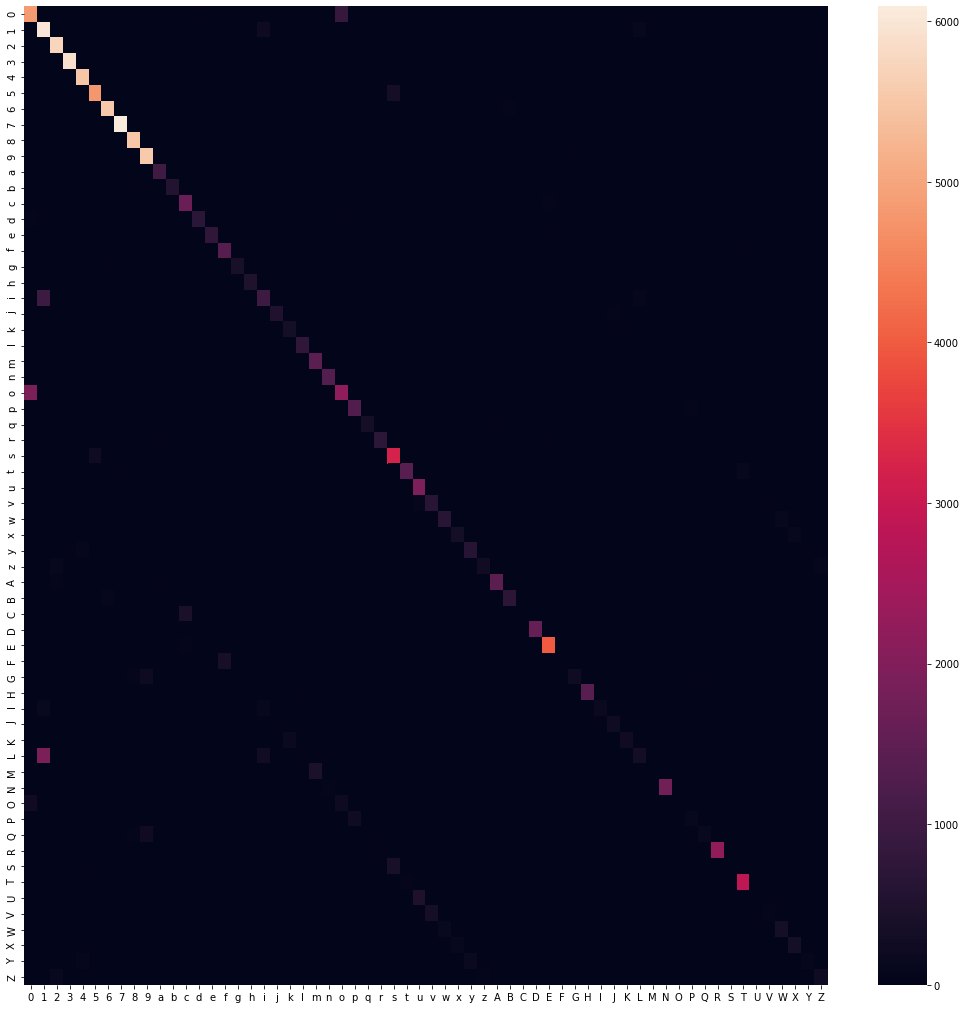

In [16]:
labels = string.digits+string.ascii_lowercase+string.ascii_uppercase
plt.subplots(figsize=(18,18))
sns.heatmap(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)), xticklabels=labels, yticklabels=labels)

# Convert model to Javascript

In [17]:
model.save("cnn_emnist.h5")

In [18]:
#!pip install tensorflowjs

In [19]:
#!rm -rf jsmodel/
#!tensorflowjs_converter --input_format keras "cnn_emnist.h5" ./jsmodel
#!zip -r jsmodel.zip jsmodel/

The JavaScript ready model is now available for download in the files panel (jsmodel.zip)

In [20]:
from __future__ import print_function
import time
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.datasets import fetch_openml


In [21]:
import emnist
dataset = fetch_openml('emnist_balanced')
X = dataset.data / 255.0
y = dataset.target

In [22]:
from sklearn.preprocessing import LabelEncoder
le= LabelEncoder()
y=le.fit_transform(y)

ValueError: ignored

In [ ]:
y=np.array(y).astype('str').tolist()
y
y1=[]
for i in y:
  y1.append(i)
y=y1
y

In [ ]:
feat_cols = [ 'pixel'+str(i) for i in range(X.shape[1]) ]
df = pd.DataFrame(X,columns=feat_cols)
df['y'] = y
df['label'] = df['y'].apply(lambda i: str(i))
X, y = None, None
print('Size of the dataframe: {}'.format(df.shape))